Then we try to solve the following ODE for harmonic oscillator:

$$\dfrac{d^2x}{dt^2}=-\omega^2 x, x(t=t_0)=x_0, \dfrac{dx}{dt}(t=t_0)=x_0^{'}$$

This problem can be formulated as a machine learning problem where the training examples are

$$(t_i, -\omega^2 x_i), i \in \{1, 2, ..., N\}$$

and the loss function is

$$\mathcal{L}(\text{NN})=(\dfrac{d^2x}{dt^2}+\omega^2 x)^2$$

where NN is the transformation learned by a neural network. We can enforce the initial condition $x(t=t_0)=x_0, \dfrac{dx}{dt}(t=t_0)=x_0^{'}$ by setting

$$x = x_0 + (t-t_0)x_0^{'} + (t-t_0)^2\text{NN}(t)$$

at the output layer of the network.

In [1]:
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torch.autograd      as autograd

import numpy as np
import matplotlib.pyplot   as plt
%matplotlib inline
from IPython.display import clear_output

from scipy.integrate import odeint

In [2]:
class FCNN(nn.Module):
    """
    A fully connected neural network.
    """
    def __init__(self, n_hidden_units, n_hidden_layers, condition, actv):
        """
        :param n_hidden_units: number of hidden units in each hidden layer
        :param n_hidden_layers: number of hidden layers
        :param condition: the initial condition of the ODE
        :param actv: the activation layer used in each hidden layer
        """
        super(FCNN, self).__init__()
        self.condition = condition
        layers = []
        layers.append(nn.Linear(1, n_hidden_units))
        layers.append(actv())
        for i in range(n_hidden_layers):
            layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            layers.append(actv())
        layers.append(nn.Linear(n_hidden_units, 1))
        self.NN = torch.nn.Sequential(*layers)

    def forward(self, t):
        x = self.NN(t)
        x = self.condition.enforce(t, x) # enforcing the initial condition
        return x

In [3]:
class Condition:
    def __init__(self, t_0, x_0, x_0_prime):
        self.t_0, self.x_0, self.x_0_prime = t_0, x_0, x_0_prime
    def enforce(self, t, x):
        return self.x_0 + (t-self.t_0)*self.x_0_prime + ((t-self.t_0)**2)*x

In [4]:
def get_examples(size, t_min=0.0, t_max=1.0, equally_spaced=False):
    examples = torch.linspace(t_min, t_max, size) if equally_spaced else torch.rand(size)*(t_max-t_min) + t_min
    examples.requires_grad = True
    return examples

In [5]:
def train(fcnn, examples, optimizer, criterion, n_epochs, batch_size):
    """
    Train a fully connected neural network to solve an ODE. It is hard coded to solve the ODE d^2x/dt^2 = -omega^2*x.
    The training is done using mini-batches.
    :param fcnn: a fully connected neural network
    :param examples: the set of ts to train the neural network on
    :param optimizer: a optimizer from pytorch.optim
    :param criterion: a loss function from pytorch.nn
    :param n_epochs: the number of passes through the training set
    :param batch_size: the size of the minibatch
    """
    n_examples = len(examples)
    if n_examples%batch_size != 0:
        # todo: I know this is stupid, I'll fix this later
        raise RuntimeError('Please choose a batch_size such that it is a factor of the size of the training set.')
    n_batches = n_examples//batch_size
    
    loss_history = np.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        loss_epoch = 0.0

        # todo: what is the right way to shuffle the training examples? using the following method requires
        # adding retain_graph=True to loss.backward(), otherwise some unknown error is raised
#         perm = torch.randperm(n_examples)
#         t_in_batches = examples[perm].reshape((n_batches, batch_size, 1))
        examples = get_examples(128, t_min, t_max)
        t_in_batches = examples.reshape((n_batches, batch_size, 1))
        for t_in in t_in_batches:
            
            # add noise to weights
#             with torch.no_grad():
#                 for param in fcnn.parameters():
#                     param.add_(torch.randn(param.size()) * 0.0001)        

            x_out = fcnn(t_in)
            
            left, right = harmonic_oscillator_ode(x_out, t_in, omega)
            loss = criterion(left, right)
            loss_epoch += loss.item()

            optimizer.zero_grad()
            loss.backward()
#             loss.backward(retain_graph=True)
            optimizer.step()
            
        loss_history[epoch] = loss_epoch/n_batches
        if epoch%100 == 0: 
            clear_output()
            print(f'epoch {epoch:5d}: loss = {loss_history[epoch]:.2e}', )
            plot_t_min, plot_t_max = t_min, t_max

            ts = np.linspace(plot_t_min, plot_t_max, 100)
            t_in  = torch.linspace(plot_t_min, plot_t_max, 100, requires_grad=True).reshape((-1, 1, 1))
            x_out = fcnn( t_in )
            left, right = harmonic_oscillator_ode(x_out, t_in, omega, requires_grad=False)
            left, right = left.detach().numpy().flatten(), right.detach().numpy().flatten()
            xs = x_out.detach().numpy().flatten()

            plt.plot(ts, xs,    label='x(t) by NN')
            plt.plot(ts, left,  label='d2x/dt2')
            plt.plot(ts, right, label='-omega^2*x')
            plt.legend()
            plt.title('solutions')
            plt.show()
    
    return loss_history

In [6]:
def harmonic_oscillator_ode(x, t, omega, requires_grad=True):
    mask = torch.ones_like(t)
    dxdt,   = autograd.grad(x,    t, create_graph=True,          grad_outputs=mask)
    d2xdt2, = autograd.grad(dxdt, t, create_graph=requires_grad, grad_outputs=mask)
    return d2xdt2, -(omega**2)*x

epoch  9900: loss = 2.37e-02


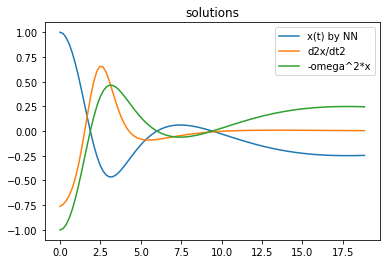

In [7]:
omega               = 1.0
t_0, x_0, x_0_prime = 0.0, 1.0, 0.0
t_min, t_max        = 0.0, 6*np.pi
actv                = nn.Sigmoid

# solve for dx/dt = x, x(t=0) = 1
initial_condition = Condition(t_0=t_0, x_0=x_0, x_0_prime=x_0_prime)
fcnn = FCNN(n_hidden_units=32, n_hidden_layers=3, condition=initial_condition, actv=actv)
# generate training examples in the range (t_min, t_max)
ts_train = get_examples(128, t_min, t_max, equally_spaced=True)
optimizer = optim.Adam(fcnn.parameters(), lr=0.0001)
criterion = nn.MSELoss()

loss_history = train(fcnn, ts_train, optimizer=optimizer, criterion=criterion,\
                     n_epochs=10000, batch_size=16)

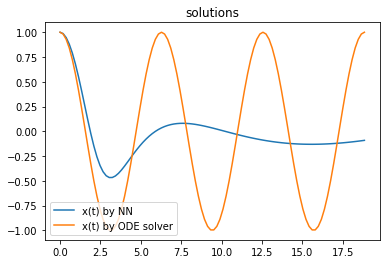

In [8]:
plot_t_min, plot_t_max = t_min, t_max

ts = np.linspace(plot_t_min, plot_t_max, 100)
t_in  = torch.linspace(plot_t_min, plot_t_max, 100, requires_grad=True).reshape((-1, 1, 1))
xs = fcnn( torch.linspace(plot_t_min, plot_t_max, 100).reshape((-1, 1, 1)) )\
     .detach().numpy().flatten()

def deriv(u, t, omega):
    x, x_prime = u
    return [x_prime, -(omega**2) * x]
xs_num = odeint(deriv, [x_0, x_0_prime], ts, args=(omega,))[:, 0]

plt.plot(ts, xs,     label='x(t) by NN')
plt.plot(ts, xs_num, label='x(t) by ODE solver')
plt.legend()
plt.title('solutions')
plt.show()

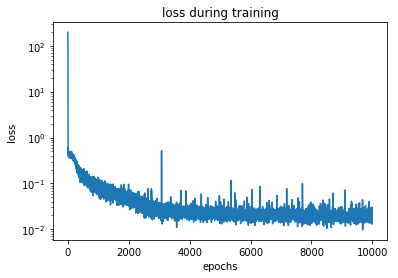

In [9]:
plt.plot(loss_history)
plt.title('loss during training')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')

The code is broken:
* seems that the optimizer is always trapped in some local minima